In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mutual_info_score,
    accuracy_score,
    mean_squared_error
)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df = df.reindex(
    ['age', 'job', 'marital', 'education', 'balance',
     'housing', 'contact', 'day', 'month', 'duration',
     'campaign', 'pdays', 'previous', 'poutcome', 'y']
, axis=1)

In [4]:
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [5]:
# What is the most frequent observation (mode) for the column education?
df.education.value_counts(ascending=False).head(1)

secondary    23202
Name: education, dtype: int64

C:\Users\49162\AppData\Local\Temp\ipykernel_12720\2108159935.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='mako')


<AxesSubplot: >

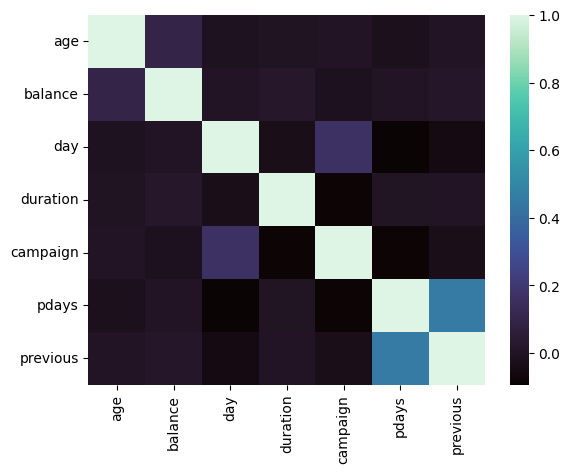

In [6]:
# What are the two features that have the biggest correlation?
sns.heatmap(df.corr(), cmap='mako')

In [7]:
df.y = df.y.map({'yes': 1, 'no': 0})

df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [8]:
def x_y_split_and_index(df, y_column):
    df.reset_index(drop=True, inplace=True)
    cols_x = df.columns[df.columns!=y_column]
    X = df[cols_x].copy()
    y = df[y_column].values
    return X, y

del df_train_val
X_train, y_train = x_y_split_and_index(df_train, 'y')
X_test, y_test = x_y_split_and_index(df_test, 'y')
X_val, y_val = x_y_split_and_index(df_val, 'y')

In [9]:
# Which of these variables has the biggest mutual information score?
cols = ['contact', 'education', 'housing', 'poutcome']
for i in cols:
    print(i, round(mutual_info_score(X_train[i], y_train), 2))

contact 0.01
education 0.0
housing 0.01
poutcome 0.03


In [10]:
# What accuracy did you get?
ohe_res = pd.get_dummies(df[cols])
ohe_df = df.drop(cols, axis=1).merge(ohe_res, left_index=True, right_index=True)

df_train_val, df_test = train_test_split(ohe_df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42)
X_train, y_train = x_y_split_and_index(df_train, 'y')
X_test, y_test = x_y_split_and_index(df_test, 'y')
X_val, y_val = x_y_split_and_index(df_val, 'y')


train_dicts = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(X_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
first_score = accuracy_score(y_val, y_pred)
round(first_score, 2)

0.9

In [11]:
# Which of following feature has the smallest difference?
def full_pipeline(model_obj, vectorizer_obj, score_obj, df, y_column):
    # split df
    df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42)
    X_train, y_train = x_y_split_and_index(df_train, y_column)
    X_test, y_test = x_y_split_and_index(df_test, y_column)
    X_val, y_val = x_y_split_and_index(df_val, y_column)
    # OHE
    train_dicts = X_train.to_dict(orient='records')
    X_train = vectorizer_obj.fit_transform(train_dicts)
    X_val = vectorizer_obj.transform(X_val.to_dict(orient='records'))
    # model fit
    model_obj.fit(X_train, y_train)
    # prediction
    y_pred = model_obj.predict(X_val)
    # scoring
    sc_ = score_obj(y_val, y_pred)
    return sc_

final_scores = {}
for i in ['age', 'balance', 'marital', 'previous']:
    df_excl = ohe_df.drop(i, axis=1).copy()
    score = full_pipeline(model, dv, accuracy_score, df_excl, 'y')
    final_scores[i] = score

{k: v-first_score for k,v in final_scores.items()}

{'age': -0.00033178500331787486,
 'balance': -0.00022119000221187957,
 'marital': -0.0014377350143773837,
 'previous': -0.00033178500331787486}

In [12]:
# Which of these C leads to the best accuracy on the validation set?
cs = [0.01, 0.1, 1, 10, 100]

ridge_results = {}
for c in cs:
    model_r = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    score_ridge = full_pipeline(model_r, dv, accuracy_score, ohe_df, 'y')
    ridge_results[c] = round(score_ridge, 3)

ridge_results

{0.01: 0.898, 0.1: 0.901, 1: 0.902, 10: 0.901, 100: 0.901}